# time-frequency analysis

In [1]:
import numpy as np

import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False).crop(tmax=60)

In [2]:
raw.compute_psd()

Effective window size : 0.426 (s)


<Power Spectrum (from Raw, welch method) | 364 channels × 129 freqs, 0.0-300.3 Hz>

In [3]:
raw.compute_psd(method='multitaper', tmin=10, tmax=20, fmin=5, fmax=30,
                picks='eeg');

    Using multitaper spectrum estimation with 7 DPSS windows


In [4]:
with mne.use_log_level('WARNING'):  # hide some irrelevant info messages
    events = mne.find_events(raw, stim_channel='STI 014')
    event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
                  'visual/right': 4}
    epochs = mne.Epochs(raw, events, tmin=-0.3, tmax=0.7, event_id=event_dict,
                        preload=True)
epo_spectrum = epochs.compute_psd()
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f'\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}')
epo_spectrum

    Using multitaper spectrum estimation with 7 DPSS windows

PSDs shape: (77, 364, 301), freqs shape: (301,)


<Power Spectrum (from Epochs, multitaper method) | 77 epochs × 364 channels × 301 freqs, 0.0-299.8 Hz>

In [5]:
evoked = epochs['auditory'].average()
evk_spectrum = evoked.compute_psd()
# the first 3 frequency bins for the first 4 channels:
print(evk_spectrum[:4, :3])

    Using multitaper spectrum estimation with 7 DPSS windows
[[5.62205637e-23 1.13776542e-22 9.90850735e-23]
 [2.89161828e-23 4.24201617e-23 3.93085560e-23]
 [1.57011939e-25 2.66195154e-25 2.39526016e-25]
 [5.38954376e-23 1.03998988e-22 9.98139252e-23]]


In [6]:
# get both "visual/left" and "visual/right" epochs:
epo_spectrum['visual']

<Power Spectrum (from Epochs, multitaper method) | 37 epochs × 364 channels × 301 freqs, 0.0-299.8 Hz>

/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


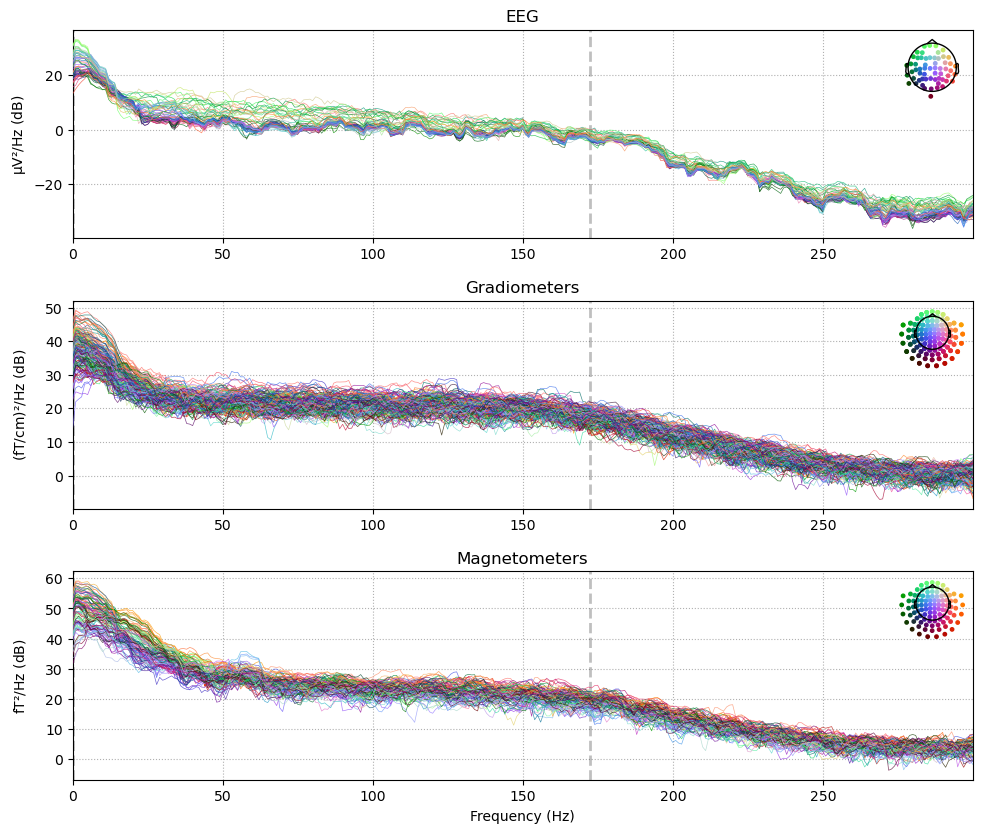

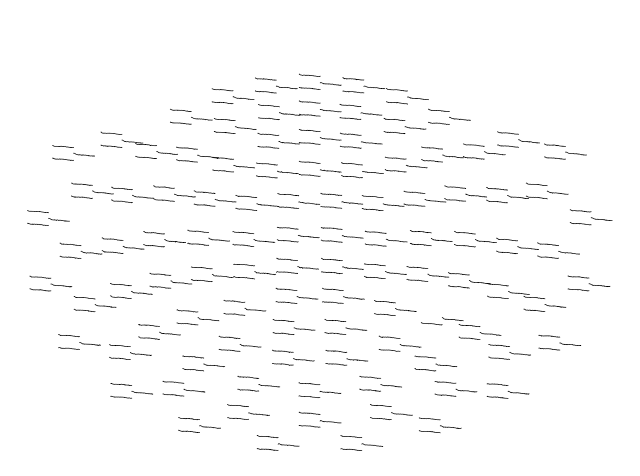

In [7]:
evk_spectrum.plot();
evk_spectrum.plot_topo(color='k', fig_facecolor='w', axis_facecolor='w');

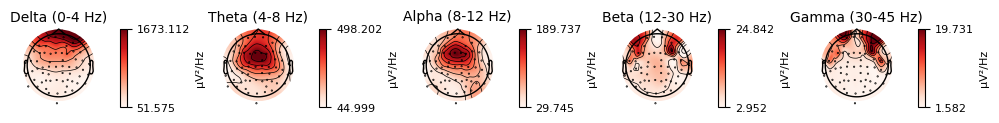

In [8]:
evk_spectrum.plot_topomap(ch_type='eeg', agg_fun=np.median);

dataset: Somatosensory. It contains so-called event related synchronizations (ERS) / desynchronizations (ERD) in the beta band.

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import somato
from mne.time_frequency import tfr_morlet

In [10]:
data_path = somato.data_path()
subject = '01'
task = 'somato'
raw_fname = (data_path / f'sub-{subject}' / 'meg' /
             f'sub-{subject}_task-{task}_meg.fif')

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
# crop and resample just to reduce computation time
raw.crop(120, 360).load_data().resample(200)
events = mne.find_events(raw, stim_channel='STI 014')

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg='grad', eeg=False, eog=True, stim=False)

# Construct Epochs
event_id, tmin, tmax = 1, -1., 3.
baseline = (None, 0)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=baseline, reject=dict(grad=4000e-13, eog=350e-6),
                    preload=True)

Using default location ~/mne_data for somato...


100%|████████████████████████████████████████| 611M/611M [00:00<00:00, 611GB/s]
Untarring contents of '/Users/DanDan/mne_data/MNE-somato-data.tar.gz' to '/Users/DanDan/mne_data'


Opening raw data file /Users/DanDan/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
Reading 0 ... 72074  =      0.000 ...   240.001 secs...
29 events found
Event IDs: [1]
29 events found
Event IDs: [1]
29 events found
Event IDs: [1]
Not setting metadata
29 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 801 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
1 bad epochs dropped


In [11]:
epochs.plot_psd(fmin=2., fmax=40., average=True);

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().
    Using multitaper spectrum estimation with 7 DPSS windows


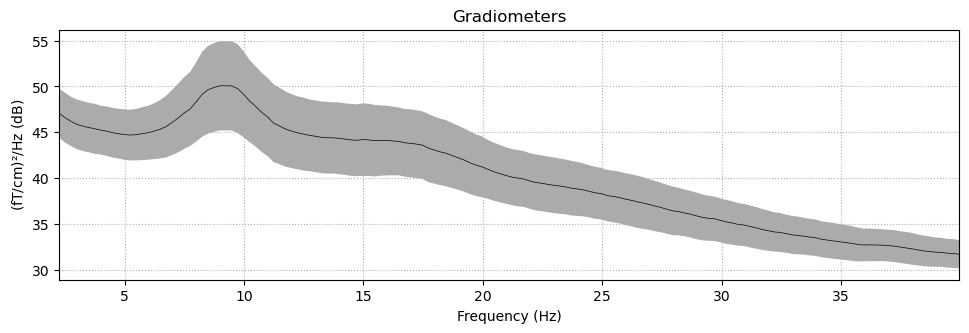

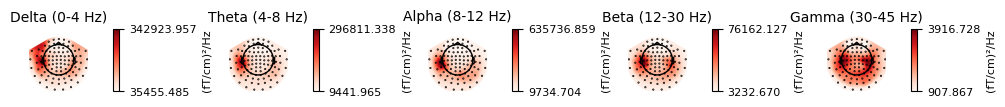

In [12]:
epochs.plot_psd_topomap(ch_type='grad', normalize=False);

In [13]:
_, ax = plt.subplots()
spectrum = epochs.compute_psd(fmin=2., fmax=40., tmax=3., n_jobs=None)
# average across epochs first
mean_spectrum = spectrum.average()
psds, freqs = mean_spectrum.get_data(return_freqs=True)
# then convert to dB and take mean & standard deviation across channels
psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5, edgecolor='none')
ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')

    Using multitaper spectrum estimation with 7 DPSS windows


[Text(0.5, 1.0, 'Multitaper PSD (gradiometers)'),
 Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (dB)')]

In [14]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=40, n_jobs=None)
psds_welch_mean, freqs_mean = epochs.compute_psd(
    'welch', average='mean', **kwargs).get_data(return_freqs=True)
psds_welch_median, freqs_median = epochs.compute_psd(
    'welch', average='median', **kwargs).get_data(return_freqs=True)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'MEG 0122'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title=f'Welch PSD ({ch_name}, Epoch {epo_idx})',
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')

Effective window size : 1.280 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 1.280 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


In [15]:
welch_unagg = epochs.compute_psd('welch', average=None, **kwargs)
print(welch_unagg.shape)

Effective window size : 1.280 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(28, 204, 49, 3)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


 time-frequency representations (TFRs)

In [16]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=None)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    2.8s finished


Applying baseline correction (mode: logratio)


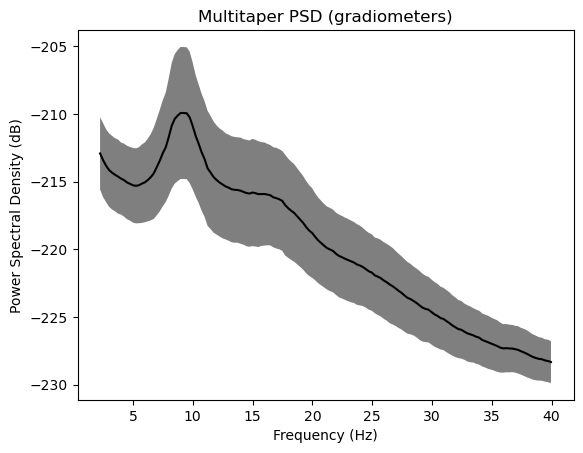

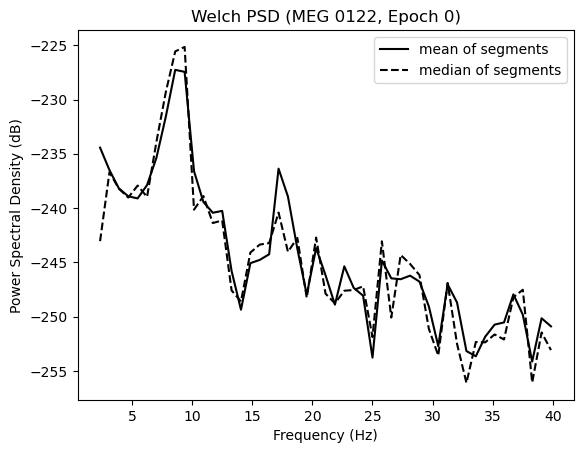

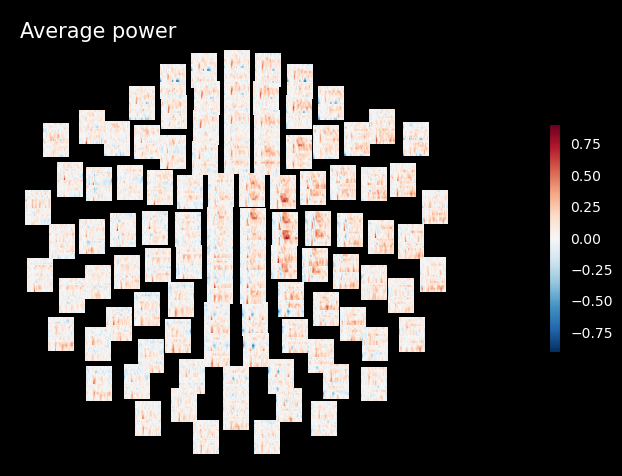

Applying baseline correction (mode: logratio)


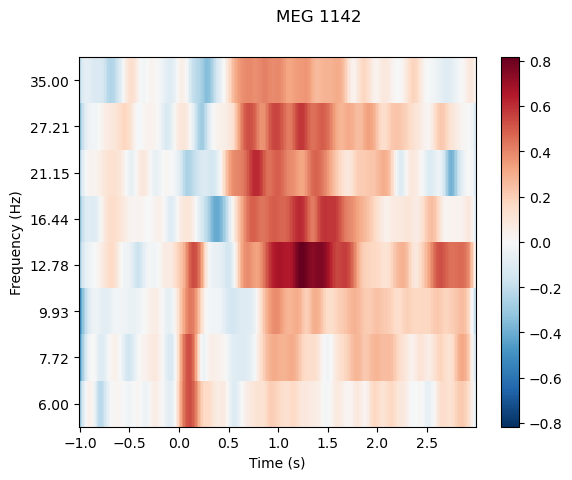

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


/var/folders/gy/vmc0g_m96tvb6cdgrbz7478r0000gn/T/ipykernel_788/3833328863.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [17]:
power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
power.plot([82], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[82])

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
topomap_kw = dict(ch_type='grad', tmin=0.5, tmax=1.5, baseline=(-0.5, 0),
                  mode='logratio', show=False)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(title)
fig.tight_layout()
fig.show()

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


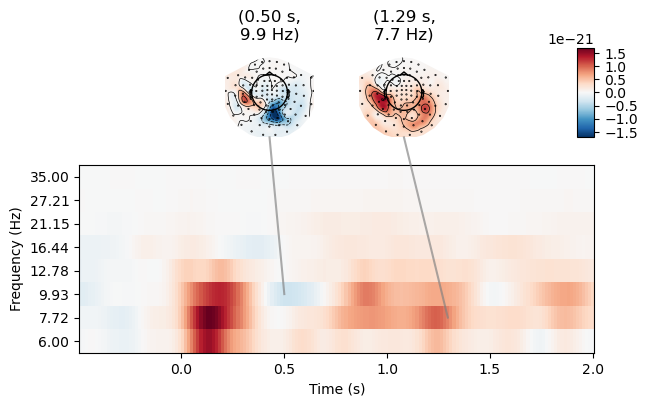

In [19]:
power.plot_joint(baseline=(-0.5, 0), mode='mean', tmin=-.5, tmax=2,
                 timefreqs=[(0.5, 10), (1.3, 8)]);

No baseline correction applied


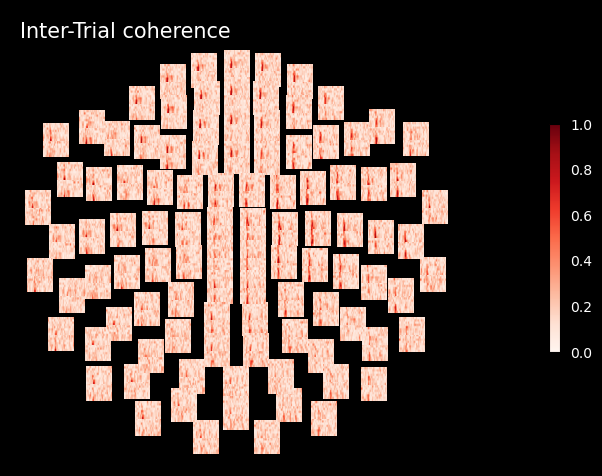

In [20]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds');

## frequency-tagging: SSVEP/vSSR dataset

In [ ]:
# signal-to-noise ration (SNR)
# fast periodic visual stimulation(FPVS) 


Extracting SNR at stimulation frequency is a simple way to quantify frequency tagged responses in MEEG (a.k.a. steady state visually evoked potentials, SSVEP, or visual steady-state responses, vSSR in the visual domain, or auditory steady-state responses, ASSR in the auditory domain)

In [21]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.stats import ttest_rel

In [22]:
# Load raw data
data_path = mne.datasets.ssvep.data_path()
bids_fname = (data_path / 'sub-02' / 'ses-01' / 'eeg' /
              'sub-02_ses-01_task-ssvep_eeg.vhdr')

raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw.info['line_freq'] = 50.

# Set montage
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference('average', projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=None, fir_design='firwin', verbose=False)

# Construct epochs
event_id = {
    '12hz': 255,
    '15hz': 155
}
events, _ = mne.events_from_annotations(raw, verbose=False)
tmin, tmax = -1., 20.  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,
    event_id=[event_id['12hz'], event_id['15hz']], tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)

In [23]:
tmin = 1.
tmax = 20.
fmin = 1.
fmax = 90.
sfreq = epochs.info['sfreq']

spectrum = epochs.compute_psd(
    'welch',
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
psds, freqs = spectrum.get_data(return_freqs=True)

In [24]:
# calculate signal to noise ratio(SNR)


def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

In [25]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

In [27]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig.show();

/var/folders/gy/vmc0g_m96tvb6cdgrbz7478r0000gn/T/ipykernel_788/674411706.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


ectract SNR values at the stimulation frequency

In [28]:
# define stimulation frequency
stim_freq = 12.

In [29]:
# find index of frequency bin closest to stimulation frequency
i_bin_12hz = np.argmin(abs(freqs - stim_freq))
# could be updated to support multiple frequencies

# for later, we will already find the 15 Hz bin and the 1st and 2nd harmonic
# for both.
i_bin_24hz = np.argmin(abs(freqs - 24))
i_bin_36hz = np.argmin(abs(freqs - 36))
i_bin_15hz = np.argmin(abs(freqs - 15))
i_bin_30hz = np.argmin(abs(freqs - 30))
i_bin_45hz = np.argmin(abs(freqs - 45))

In [31]:
i_trial_12hz = np.where(epochs.events[:, 2] == event_id['12hz'])[0]
i_trial_15hz = np.where(epochs.events[:, 2] == event_id['15hz'])[0]

In [32]:
# Define different ROIs
roi_vis = ['POz', 'Oz', 'O1', 'O2', 'PO3', 'PO4', 'PO7',
           'PO8', 'PO9', 'PO10', 'O9', 'O10']  # visual roi

# Find corresponding indices using mne.pick_types()
picks_roi_vis = mne.pick_types(epochs.info, eeg=True, stim=False,
                               exclude='bads', selection=roi_vis)

In [33]:
snrs_target = snrs[i_trial_12hz, :, i_bin_12hz][:, picks_roi_vis]
print("sub 2, 12 Hz trials, SNR at 12 Hz")
print(f'average SNR (occipital ROI): {snrs_target.mean()}')

sub 2, 12 Hz trials, SNR at 12 Hz
average SNR (occipital ROI): 41.69365541718619


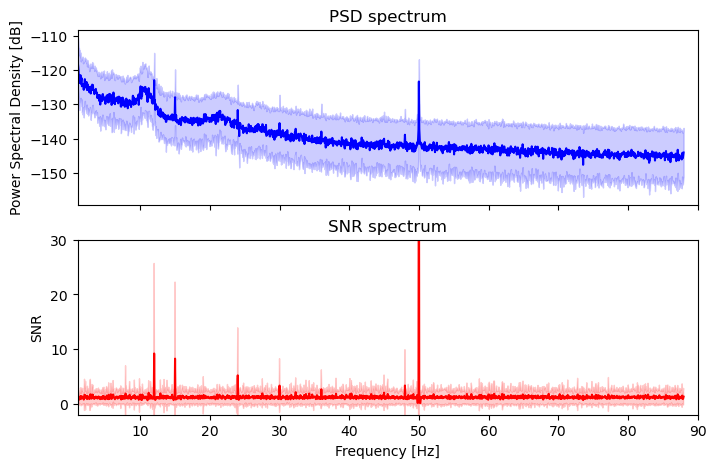

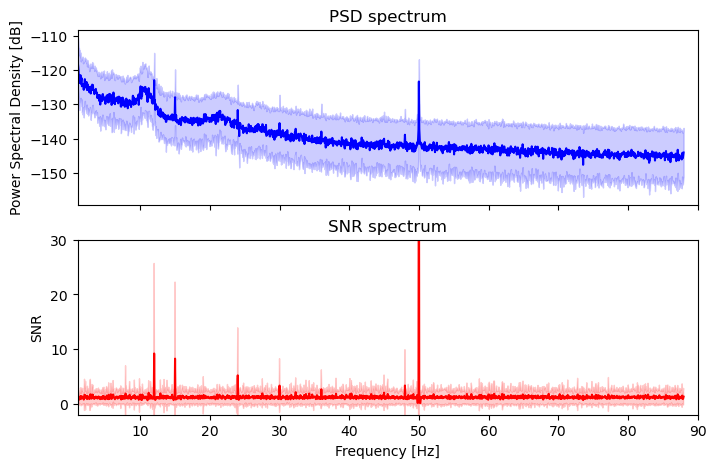

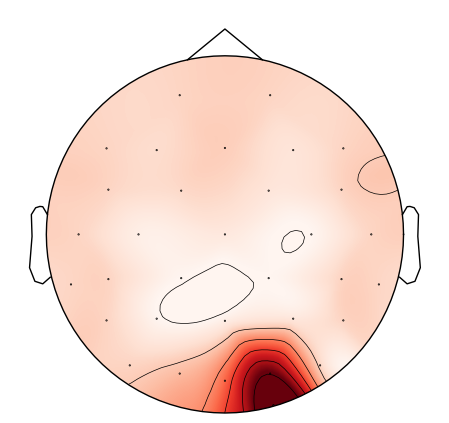

sub 2, 12 Hz trials, SNR at 12 Hz
average SNR (all channels): 16.985902
average SNR (occipital ROI): 41.693655
12 Hz SNR in occipital ROI is significantly larger than 12 Hz SNR over all channels: t = 6.950, p = 0.000067


In [34]:
# get average SNR at 12 Hz for ALL channels
snrs_12hz = snrs[i_trial_12hz, :, i_bin_12hz]
snrs_12hz_chaverage = snrs_12hz.mean(axis=0)

# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_12hz_chaverage, epochs.info, vlim=(1, None), axes=ax)

print("sub 2, 12 Hz trials, SNR at 12 Hz")
print("average SNR (all channels): %f" % snrs_12hz_chaverage.mean())
print("average SNR (occipital ROI): %f" % snrs_target.mean())

tstat_roi_vs_scalp = \
    ttest_rel(snrs_target.mean(axis=1), snrs_12hz.mean(axis=1))
print("12 Hz SNR in occipital ROI is significantly larger than 12 Hz SNR over "
      "all channels: t = %.3f, p = %f" % tstat_roi_vs_scalp)

In [35]:
snrs_roi = snrs[:, picks_roi_vis, :].mean(axis=1)

freq_plot = [12, 15, 24, 30, 36, 45]
color_plot = [
    'darkblue', 'darkgreen', 'mediumblue', 'green', 'blue', 'seagreen'
]
xpos_plot = [-5. / 12, -3. / 12, -1. / 12, 1. / 12, 3. / 12, 5. / 12]
fig, ax = plt.subplots()
labels = ['12 Hz trials', '15 Hz trials']
x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
res = dict()

# loop to plot SNRs at stimulation frequencies and harmonics
for i, f in enumerate(freq_plot):
    # extract snrs
    stim_12hz_tmp = \
        snrs_roi[i_trial_12hz, np.argmin(abs(freqs - f))]
    stim_15hz_tmp = \
        snrs_roi[i_trial_15hz, np.argmin(abs(freqs - f))]
    SNR_tmp = [stim_12hz_tmp.mean(), stim_15hz_tmp.mean()]
    # plot (with std)
    ax.bar(
        x + width * xpos_plot[i], SNR_tmp, width / len(freq_plot),
        yerr=np.std(SNR_tmp),
        label='%i Hz SNR' % f, color=color_plot[i])
    # store results for statistical comparison
    res['stim_12hz_snrs_%ihz' % f] = stim_12hz_tmp
    res['stim_15hz_snrs_%ihz' % f] = stim_15hz_tmp

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SNR')
ax.set_title('Average SNR at target frequencies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(['%i Hz' % f for f in freq_plot], title='SNR at:')
ax.set_ylim([0, 70])
ax.axhline(1, ls='--', c='r')
fig.show()

/var/folders/gy/vmc0g_m96tvb6cdgrbz7478r0000gn/T/ipykernel_788/2278598082.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [36]:
# Compare 12 Hz and 15 Hz SNR in trials after averaging over channels

tstat_12hz_trial_stim = \
    ttest_rel(res['stim_12hz_snrs_12hz'], res['stim_12hz_snrs_15hz'])
print("12 Hz Trials: 12 Hz SNR is significantly higher than 15 Hz SNR"
      ": t = %.3f, p = %f" % tstat_12hz_trial_stim)

tstat_12hz_trial_1st_harmonic = \
    ttest_rel(res['stim_12hz_snrs_24hz'], res['stim_12hz_snrs_30hz'])
print("12 Hz Trials: 24 Hz SNR is significantly higher than 30 Hz SNR"
      ": t = %.3f, p = %f" % tstat_12hz_trial_1st_harmonic)

tstat_12hz_trial_2nd_harmonic = \
    ttest_rel(res['stim_12hz_snrs_36hz'], res['stim_12hz_snrs_45hz'])
print("12 Hz Trials: 36 Hz SNR is significantly higher than 45 Hz SNR"
      ": t = %.3f, p = %f" % tstat_12hz_trial_2nd_harmonic)

print()
tstat_15hz_trial_stim = \
    ttest_rel(res['stim_15hz_snrs_12hz'], res['stim_15hz_snrs_15hz'])
print("15 Hz trials: 12 Hz SNR is significantly lower than 15 Hz SNR"
      ": t = %.3f, p = %f" % tstat_15hz_trial_stim)

tstat_15hz_trial_1st_harmonic = \
    ttest_rel(res['stim_15hz_snrs_24hz'], res['stim_15hz_snrs_30hz'])
print("15 Hz trials: 24 Hz SNR is significantly lower than 30 Hz SNR"
      ": t = %.3f, p = %f" % tstat_15hz_trial_1st_harmonic)

tstat_15hz_trial_2nd_harmonic = \
    ttest_rel(res['stim_15hz_snrs_36hz'], res['stim_15hz_snrs_45hz'])
print("15 Hz trials: 36 Hz SNR is significantly lower than 45 Hz SNR"
      ": t = %.3f, p = %f" % tstat_15hz_trial_2nd_harmonic)

12 Hz Trials: 12 Hz SNR is significantly higher than 15 Hz SNR: t = 7.510, p = 0.000037
12 Hz Trials: 24 Hz SNR is significantly higher than 30 Hz SNR: t = 8.489, p = 0.000014
12 Hz Trials: 36 Hz SNR is significantly higher than 45 Hz SNR: t = 14.899, p = 0.000000

15 Hz trials: 12 Hz SNR is significantly lower than 15 Hz SNR: t = -5.692, p = 0.000297
15 Hz trials: 24 Hz SNR is significantly lower than 30 Hz SNR: t = -7.916, p = 0.000024
15 Hz trials: 36 Hz SNR is significantly lower than 45 Hz SNR: t = -3.519, p = 0.006525


In [37]:
# effect of trail duration on SNR

stim_bandwidth = .5

# shorten data and welch window
window_lengths = [i for i in range(2, 21, 2)]
window_snrs = [[]] * len(window_lengths)
for i_win, win in enumerate(window_lengths):
    # compute spectrogram
    this_spectrum = epochs[str(event_id['12hz'])].compute_psd(
        'welch',
        n_fft=int(sfreq * win),
        n_overlap=0, n_per_seg=None,
        tmin=0, tmax=win,
        window='boxcar',
        fmin=fmin, fmax=fmax, verbose=False)
    windowed_psd, windowed_freqs = this_spectrum.get_data(return_freqs=True)
    # define a bandwidth of 1 Hz around stimfreq for SNR computation
    bin_width = windowed_freqs[1] - windowed_freqs[0]
    skip_neighbor_freqs = \
        round((stim_bandwidth / 2) / bin_width - bin_width / 2. - .5) if (
            bin_width < stim_bandwidth) else 0
    n_neighbor_freqs = \
        int((sum((windowed_freqs <= 13) & (windowed_freqs >= 11)
                 ) - 1 - 2 * skip_neighbor_freqs) / 2)
    # compute snr
    windowed_snrs = \
        snr_spectrum(
            windowed_psd,
            noise_n_neighbor_freqs=n_neighbor_freqs if (
                n_neighbor_freqs > 0
            ) else 1,
            noise_skip_neighbor_freqs=skip_neighbor_freqs)
    window_snrs[i_win] = \
        windowed_snrs[
        :, picks_roi_vis,
        np.argmin(
            abs(windowed_freqs - 12.))].mean(axis=1)

fig, ax = plt.subplots(1)
ax.boxplot(window_snrs, labels=window_lengths, vert=True)
ax.set(title='Effect of trial duration on 12 Hz SNR',
       ylabel='Average SNR', xlabel='Trial duration [s]')
ax.axhline(1, ls='--', c='r')
fig.show()

/var/folders/gy/vmc0g_m96tvb6cdgrbz7478r0000gn/T/ipykernel_788/1088591844.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [38]:
# time resolved SNR

# 3s sliding window
window_length = 4
window_starts = [i for i in range(20 - window_length)]
window_snrs = [[]] * len(window_starts)

for i_win, win in enumerate(window_starts):
    # compute spectrogram
    this_spectrum = epochs[str(event_id['12hz'])].compute_psd(
        'welch',
        n_fft=int(sfreq * window_length) - 1,
        n_overlap=0, n_per_seg=None,
        window='boxcar',
        tmin=win, tmax=win + window_length,
        fmin=fmin, fmax=fmax,
        verbose=False)
    windowed_psd, windowed_freqs = this_spectrum.get_data(return_freqs=True)
    # define a bandwidth of 1 Hz around stimfreq for SNR computation
    bin_width = windowed_freqs[1] - windowed_freqs[0]
    skip_neighbor_freqs = \
        round((stim_bandwidth / 2) / bin_width - bin_width / 2. - .5) if (
            bin_width < stim_bandwidth) else 0
    n_neighbor_freqs = \
        int((sum((windowed_freqs <= 13) & (windowed_freqs >= 11)
                 ) - 1 - 2 * skip_neighbor_freqs) / 2)
    # compute snr
    windowed_snrs = snr_spectrum(
        windowed_psd,
        noise_n_neighbor_freqs=n_neighbor_freqs if (
            n_neighbor_freqs > 0) else 1,
        noise_skip_neighbor_freqs=skip_neighbor_freqs)
    window_snrs[i_win] = \
        windowed_snrs[:, picks_roi_vis, np.argmin(
            abs(windowed_freqs - 12.))].mean(axis=1)

fig, ax = plt.subplots(1)
colors = plt.colormaps['Greys'](np.linspace(0, 1, 10))
for i in range(10):
    ax.plot(window_starts, np.array(window_snrs)[:, i], color=colors[i])
ax.set(title='Time resolved 12 Hz SNR - %is sliding window' % window_length,
       ylabel='Average SNR', xlabel='t0 of analysis window [s]')
ax.axhline(1, ls='--', c='r')
ax.legend(['individual trials in greyscale'])
fig.show()

/var/folders/gy/vmc0g_m96tvb6cdgrbz7478r0000gn/T/ipykernel_788/2855318312.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
